FIRST STEPS

In [ ]:
from utils import *
from validation import *


train_images_b, train_labels_b = load_dataset_split('data/original/balanced/train')
val_images_b, val_labels_b = load_dataset_split('data/original/balanced/val')
test_images_b, test_labels_b = load_dataset_split('data/original/balanced/test')

train_images_f, train_labels_f = load_dataset_split('data/augmented/FracAtlas/train')
val_images_f, val_labels_f = load_dataset_split('data/augmented/FracAtlas/val')
test_images_f, test_labels_f = load_dataset_split('data/augmented/FracAtlas/test')

train_images = np.concatenate([train_images_b, train_images_f])
train_labels = np.concatenate([train_labels_b, train_labels_f])
test_images = np.concatenate([test_images_b, test_images_f])
test_labels = np.concatenate([test_labels_b, test_labels_f])
val_images = np.concatenate([val_images_b, val_images_f])
val_labels = np.concatenate([val_labels_b, val_labels_f])





In [16]:

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:

class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(train_labels), 
                                   y=train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1]}


In [18]:
from tensorflow.keras import regularizers
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

In [19]:

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6
)

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
320/320 [==============================] - 22s 63ms/step - loss: 1.1592 - accuracy: 0.8711 - precision_1: 0.9087 - recall_1: 0.8460 - auc_1: 0.9380 - val_loss: 1.6666 - val_accuracy: 0.4983 - val_precision_1: 0.9231 - val_recall_1: 0.0201 - val_auc_1: 0.6459 - lr: 0.0010
Epoch 2/100
320/320 [==============================] - 20s 64ms/step - loss: 0.5421 - accuracy: 0.8616 - precision_1: 0.8978 - recall_1: 0.8389 - auc_1: 0.9280 - val_loss: 1.6041 - val_accuracy: 0.5060 - val_precision_1: 1.0000 - val_recall_1: 0.0334 - val_auc_1: 0.7681 - lr: 0.0010
Epoch 3/100
320/320 [==============================] - 19s 58ms/step - loss: 0.4510 - accuracy: 0.8705 - precision_1: 0.9022 - recall_1: 0.8524 - auc_1: 0.9360 - val_loss: 2.2155 - val_accuracy: 0.4949 - val_precision_1: 1.0000 - val_recall_1: 0.0117 - val_auc_1: 0.7500 - lr: 0.0010
Epoch 4/100
320/320 [==============================] - 20s 62ms/step - loss: 0.4330 - accuracy: 0.8722 - precision_1: 0.9115 - recall_1: 0.8451 - au

In [20]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

37/37 [==============================] - 1s 19ms/step - loss: 0.2580 - accuracy: 0.9281 - precision_1: 0.9292 - recall_1: 0.9381 - auc_1: 0.9721
Test Accuracy: 0.9280821681022644
Test Precision: 0.9292452931404114
Test Recall: 0.938095211982727
Test AUC: 0.9721395969390869


37/37 [==============================] - 1s 18ms/step


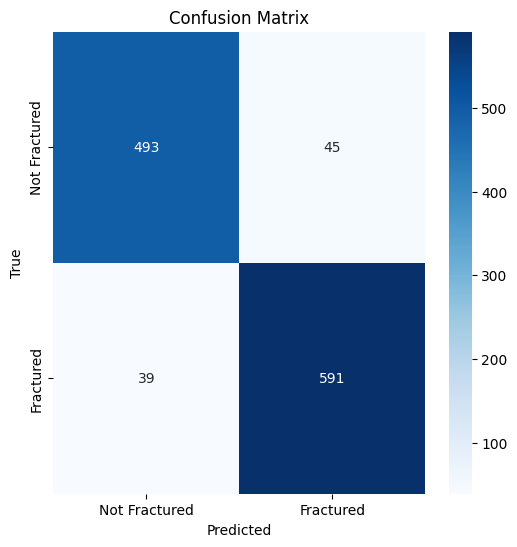

In [21]:
plot_conf_matrix(model, test_images, test_labels)

In [22]:
filename = 'binary_model_v3_augmented_reg.pkl'
create_pkl(filename, model)

In [29]:
model.save('binary_model_v3_augmented_reg.keras')

37/37 [==============================] - 1s 20ms/step


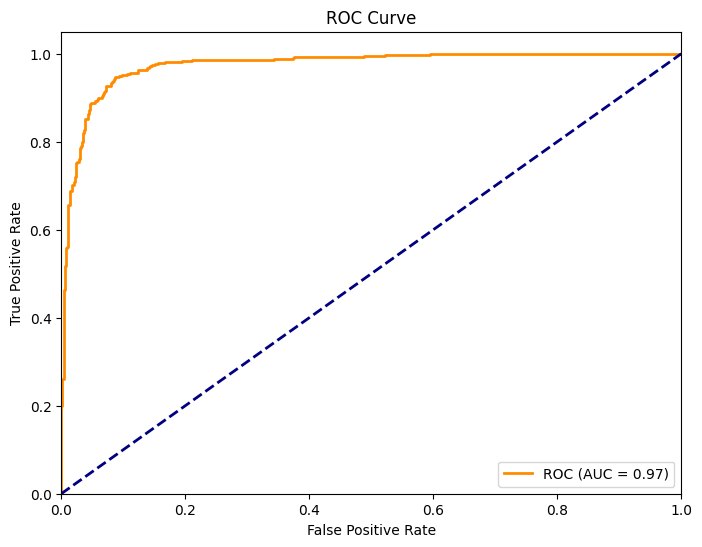

In [23]:
plot_roc_curve(model, test_images, test_labels)

37/37 [==============================] - 1s 19ms/step


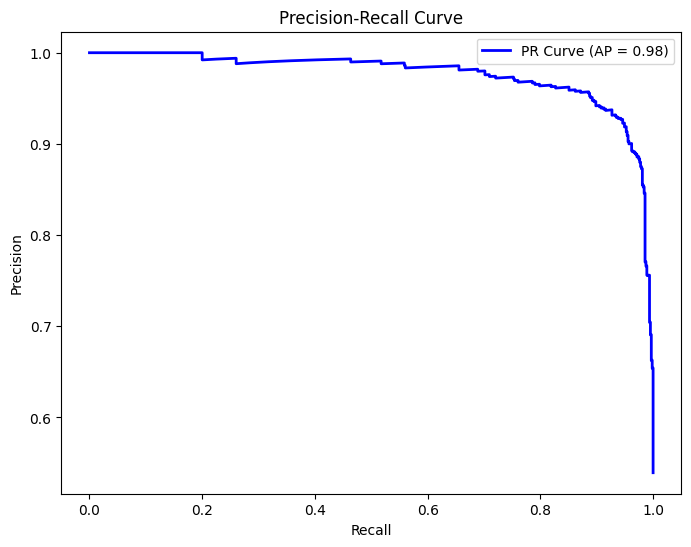

In [24]:
plot_pr_curve(model, test_images, test_labels)

37/37 [==============================] - 1s 19ms/step


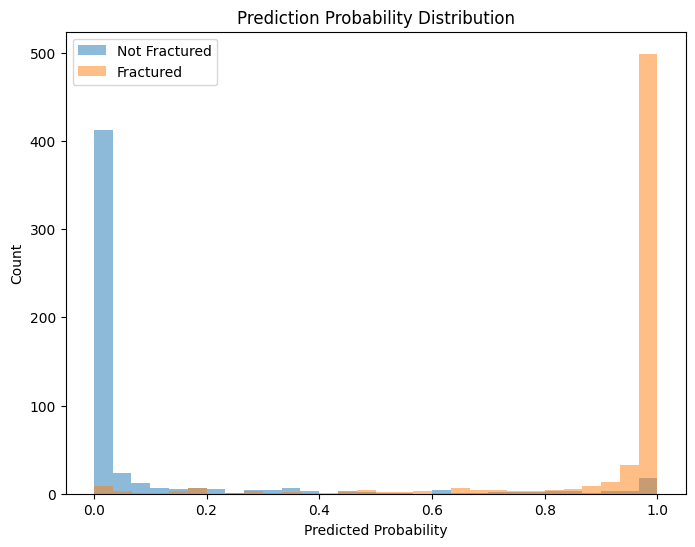

In [25]:
p_proba_dist(model, test_images, test_labels)

37/37 [==============================] - 1s 17ms/step


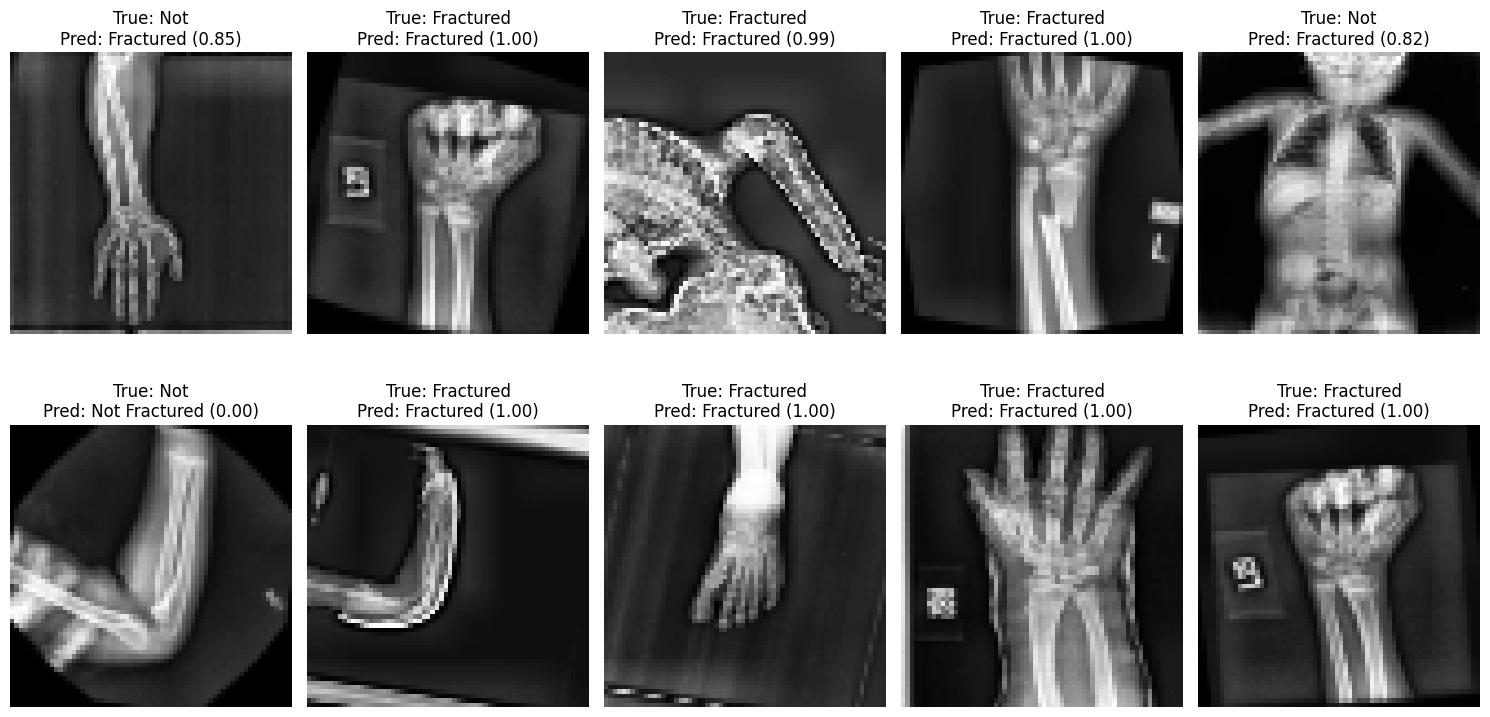

In [26]:
show_ten_samples(model, test_images, test_labels)

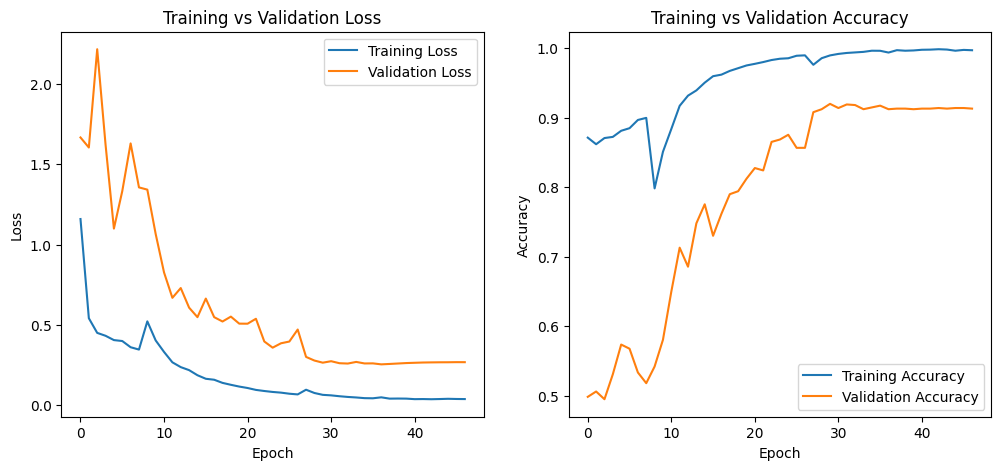

In [27]:
loss_accu_train(history)

Revisando las métricas, vamos a ajustar 8 epochs el modelo.